# DS-SF-30 | Codealong 05: k-Nearest Neighbors

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 10)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

from sklearn import preprocessing, neighbors, grid_search, cross_validation

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

/Users/vdodla/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
df = pd.read_csv(os.path.join('..', 'datasets', 'dataset-05-iris.csv'))

In [3]:
df

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
0,5.1,3.5,1.4,0.2,Setosa
1,4.9,3.0,1.4,0.2,Setosa
2,4.7,3.2,1.3,0.2,Setosa
3,4.6,3.1,1.5,0.2,Setosa
4,5.0,3.6,1.4,0.2,Setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Virginica
146,6.3,2.5,5.0,1.9,Virginica
147,6.5,3.0,5.2,2.0,Virginica
148,6.2,3.4,5.4,2.3,Virginica


In [4]:
df.describe()

,SepalLength,SepalWidth,PetalLength,PetalWidth
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [5]:
df.corr()

,SepalLength,SepalWidth,PetalLength,PetalWidth
SepalLength,1.000000,-0.109369,0.871754,0.817954
SepalWidth,-0.109369,1.000000,-0.420516,-0.356544
PetalLength,0.871754,-0.420516,1.000000,0.962757
PetalWidth,0.817954,-0.356544,0.962757,1.000000


## Part A - Activity | Iris dataset: Exploratory Data Analysis

In [18]:
color = df.Species.map({'Setosa': 'red', 'Versicolor': 'green', 'Virginica': 'blue'})

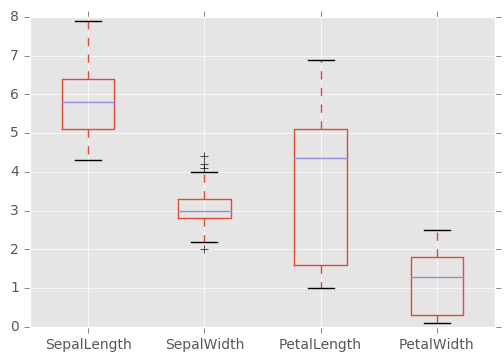

In [10]:
df.plot(kind = 'box')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x119b5ce50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a9a7190>]], dtype=object)

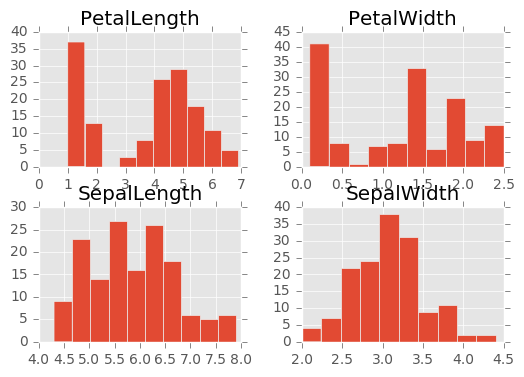

In [14]:
df.hist()

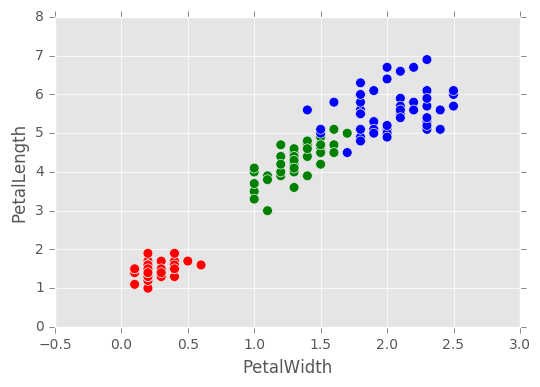

In [21]:
df.plot(kind = 'scatter', x = 'PetalWidth', y = 'PetalLength', s = 50, c = color)

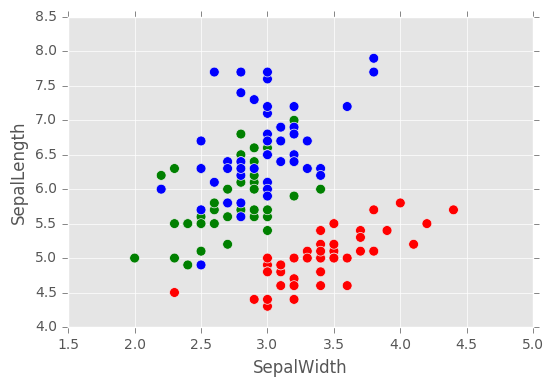

In [22]:
df.plot(kind = 'scatter', x = 'SepalWidth', y = 'SepalLength', s = 50, c = color)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11d5b5c90>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11f93c190>]], dtype=object)

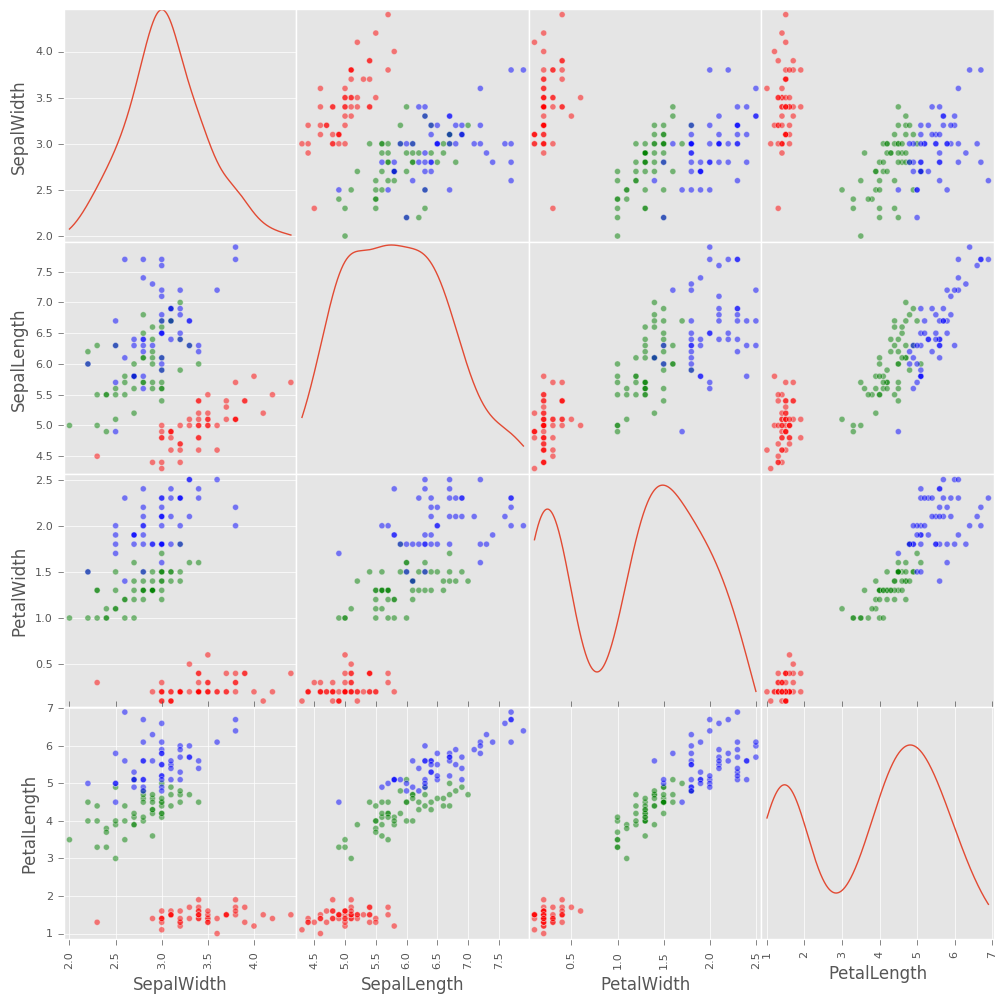

In [26]:
pd.tools.plotting.scatter_matrix(df[['SepalWidth', 'SepalLength', 'PetalWidth', 'PetalLength']],
                                diagonal = 'kde', s = 75, c = color, figsize = (12, 12))

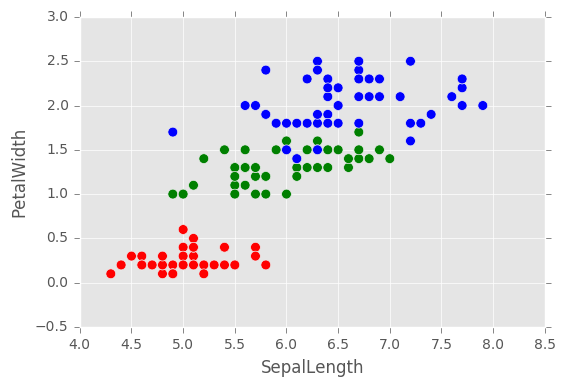

In [29]:
df.plot(kind = 'scatter', y = 'PetalWidth', x = 'SepalLength', s = 50, c = color)

## Part B - Hand-coded classifier

In [27]:
c = df.Species

In [63]:
def my_first_classifier(row):
    if row.PetalWidth < 0.75:
        return 'Setosa'
    elif row.PetalWidth < 1.75:
        return 'Versicolor'
    else:
        return 'Virginica'

In [64]:
c_hat = df.apply(my_first_classifier, axis = 1)

c_hat

0         Setosa
1         Setosa
2         Setosa
3         Setosa
4         Setosa
         ...    
145    Virginica
146    Virginica
147    Virginica
148    Virginica
149    Virginica
dtype: object

In [65]:
(c_hat != c).sum()

6

In [66]:
pd.crosstab(c_hat, c)

Species,Setosa,Versicolor,Virginica
row_0,,,
Setosa,50,0,0
Versicolor,0,49,5
Virginica,0,1,45


## Part C - Classification metrics

### Accuracy

In [68]:
(c == c_hat).mean()

0.95999999999999996

### Misclassification rate

In [69]:
(c != c_hat).mean()

0.040000000000000001

## Part D - k-Nearest Neighbors (k-NN)

### Feature matrix and response vector

In [70]:
X = df[ ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth'] ]

scaler = preprocessing.MinMaxScaler().fit(X)

X = scaler.transform(X)

In [71]:
X

array([[ 0.22222222,  0.625     ,  0.06779661,  0.04166667],
       [ 0.16666667,  0.41666667,  0.06779661,  0.04166667],
       [ 0.11111111,  0.5       ,  0.05084746,  0.04166667],
       [ 0.08333333,  0.45833333,  0.08474576,  0.04166667],
       [ 0.19444444,  0.66666667,  0.06779661,  0.04166667],
       [ 0.30555556,  0.79166667,  0.11864407,  0.125     ],
       [ 0.08333333,  0.58333333,  0.06779661,  0.08333333],
       [ 0.19444444,  0.58333333,  0.08474576,  0.04166667],
       [ 0.02777778,  0.375     ,  0.06779661,  0.04166667],
       [ 0.16666667,  0.45833333,  0.08474576,  0.        ],
       [ 0.30555556,  0.70833333,  0.08474576,  0.04166667],
       [ 0.13888889,  0.58333333,  0.10169492,  0.04166667],
       [ 0.13888889,  0.41666667,  0.06779661,  0.        ],
       [ 0.        ,  0.41666667,  0.01694915,  0.        ],
       [ 0.41666667,  0.83333333,  0.03389831,  0.04166667],
       [ 0.38888889,  1.        ,  0.08474576,  0.125     ],
       [ 0.30555556,  0.

In [72]:
c = df.Species

In [73]:
c

0         Setosa
1         Setosa
2         Setosa
3         Setosa
4         Setosa
         ...    
145    Virginica
146    Virginica
147    Virginica
148    Virginica
149    Virginica
Name: Species, dtype: object

In [74]:
model = neighbors.KNeighborsClassifier(n_neighbors = 1).fit(X, c)

You can measure the precision of your prediction with `.score()`

In [75]:
model.score(X, c)

1.0

In [76]:
c_hat = model.predict(X)

In [77]:
(c_hat == c).mean()

1.0

In [78]:
pd.crosstab(c_hat, c, rownames = ['Hypothesized Class'], colnames = ['True Class'])

True Class,Setosa,Versicolor,Virginica
Hypothesized Class,,,
Setosa,50,0,0
Versicolor,0,50,0
Virginica,0,0,50


### Train/test sets

50% of the dataset to train the model; the rest to test the model

In [133]:
train_df = df.sample(frac = .5, random_state = 0).sort_index()

In [134]:
train_df

,SepalLength,SepalWidth,PetalLength,PetalWidth,Species
2,4.7,3.2,1.3,0.2,Setosa
7,5.0,3.4,1.5,0.2,Setosa
8,4.4,2.9,1.4,0.2,Setosa
10,5.4,3.7,1.5,0.2,Setosa
13,4.3,3.0,1.1,0.1,Setosa
...,...,...,...,...,...
137,6.4,3.1,5.5,1.8,Virginica
141,6.9,3.1,5.1,2.3,Virginica
144,6.7,3.3,5.7,2.5,Virginica
146,6.3,2.5,5.0,1.9,Virginica


In [135]:
test_df = df.drop(train_df.index)

### Feature matrix `train_X` and response vector `train_c`

In [147]:
train_X = train_df[ ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth'] ]

scaler = preprocessing.MinMaxScaler().fit(train_X)
train_X = scaler.transform(train_X)

train_c = train_df.Species

### Feature matrix `test_X` and response vector `test_c`

In [148]:
test_X = test_df[['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']]
#scaler = preprocessing.MinMaxScaler().fit(test_X)
test_X = scaler.transform(test_X)
test_c = test_df.Species

In [149]:
k_cv = 5 # 5-fold CV
k_nn = range(1, train_df.shape[0] * (k_cv - 1) / k_cv) # k-NN

gs = grid_search.GridSearchCV(
    estimator = neighbors.KNeighborsClassifier(),
    param_grid = {'n_neighbors': k_nn, 'weights': ['uniform', 'distance']},
    cv = cross_validation.KFold(train_df.shape[0], n_folds = k_cv)
)

gs.fit(train_X, train_c)

GridSearchCV(cv=sklearn.cross_validation.KFold(n=75, n_folds=5, shuffle=False, random_state=None),
       error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59], 'weights': ['uniform', 'distance']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [150]:
gs.grid_scores_

[mean: 0.90667, std: 0.12365, params: {'n_neighbors': 1, 'weights': 'uniform'},
 mean: 0.90667, std: 0.12365, params: {'n_neighbors': 1, 'weights': 'distance'},
 mean: 0.88000, std: 0.14847, params: {'n_neighbors': 2, 'weights': 'uniform'},
 mean: 0.90667, std: 0.12365, params: {'n_neighbors': 2, 'weights': 'distance'},
 mean: 0.90667, std: 0.12365, params: {'n_neighbors': 3, 'weights': 'uniform'},
 mean: 0.90667, std: 0.12365, params: {'n_neighbors': 3, 'weights': 'distance'},
 mean: 0.88000, std: 0.17588, params: {'n_neighbors': 4, 'weights': 'uniform'},
 mean: 0.92000, std: 0.09798, params: {'n_neighbors': 4, 'weights': 'distance'},
 mean: 0.88000, std: 0.14236, params: {'n_neighbors': 5, 'weights': 'uniform'},
 mean: 0.90667, std: 0.12365, params: {'n_neighbors': 5, 'weights': 'distance'},
 mean: 0.85333, std: 0.22862, params: {'n_neighbors': 6, 'weights': 'uniform'},
 mean: 0.90667, std: 0.12365, params: {'n_neighbors': 6, 'weights': 'distance'},
 mean: 0.85333, std: 0.19505, para

In [151]:
gs.best_score_

0.92000000000000004

In [152]:
gs.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [153]:
gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=4, p=2,
           weights='distance')

In [154]:
gs.score(train_X, train_c)

1.0

In [155]:
gs.score(test_X, test_c)

0.97333333333333338

## Final model

In [156]:
model = gs.best_estimator_.fit(X, c)